In [ ]:
%matplotlib inline








# Decoding (MVPA)

.. include:: ../../links.inc

## Design philosophy
Decoding (a.k.a. MVPA) in MNE largely follows the machine learning API of the
scikit-learn package.
Each estimator implements ``fit``, ``transform``, ``fit_transform``, and
(optionally) ``inverse_transform`` methods. For more details on this design,
visit scikit-learn_. For additional theoretical insights into the decoding
framework in MNE :footcite:`KingEtAl2018`.

For ease of comprehension, we will denote instantiations of the class using
the same name as the class but in small caps instead of camel cases.

Let's start by loading data for a simple two-class problem:


sphinx_gallery_thumbnail_number = 6



In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

data_path = sample.data_path()

subjects_dir = data_path / 'subjects'
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_filt-0-40_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname)
raw.pick_types(meg='grad', stim=True, eog=True, exclude=())

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the example to run faster. The 2 Hz high-pass helps improve CSP.
raw.load_data().filter(2, 20)
events = mne.find_events(raw, 'STI 014')

# Set up bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443']  # bads + 2 more

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=3,
                    verbose='error')
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG
del raw

X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

Opening raw data file E:\Python LYW\RSA\MNEtutorial\DATA\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


319 events found
Event IDs: [ 1  2  3  4  5 32]


[Parallel(n_jobs=1)]: Done 204 out of 204 | elapsed:    0.2s finished


## Transformation classes

### Scaler
The :class:`mne.decoding.Scaler` will standardize the data based on channel
scales. In the simplest modes ``scalings=None`` or ``scalings=dict(...)``,
each data channel type (e.g., mag, grad, eeg) is treated separately and
scaled by a constant. This is the approach used by e.g.,
:func:`mne.compute_covariance` to standardize channel scales.

If ``scalings='mean'`` or ``scalings='median'``, each channel is scaled using
empirical measures. Each channel is scaled independently by the mean and
standand deviation, or median and interquartile range, respectively, across
all epochs and time points during :class:`~mne.decoding.Scaler.fit`
(during training). The :meth:`~mne.decoding.Scaler.transform` method is
called to transform data (training or test set) by scaling all time points
and epochs on a channel-by-channel basis. To perform both the ``fit`` and
``transform`` operations in a single call, the
:meth:`~mne.decoding.Scaler.fit_transform` method may be used. To invert the
transform, :meth:`~mne.decoding.Scaler.inverse_transform` can be used. For
``scalings='median'``, scikit-learn_ version 0.17+ is required.

<div class="alert alert-info"><h4>Note</h4><p>Using this class is different from directly applying
          :class:`sklearn.preprocessing.StandardScaler` or
          :class:`sklearn.preprocessing.RobustScaler` offered by
          scikit-learn_. These scale each *classification feature*, e.g.
          each time point for each channel, with mean and standard
          deviation computed across epochs, whereas
          :class:`mne.decoding.Scaler` scales each *channel* using mean and
          standard deviation computed across all of its time points
          and epochs.</p></div>

### Vectorizer
Scikit-learn API provides functionality to chain transformers and estimators
by using :class:`sklearn.pipeline.Pipeline`. We can construct decoding
pipelines and perform cross-validation and grid-search. However scikit-learn
transformers and estimators generally expect 2D data
(n_samples * n_features), whereas MNE transformers typically output data
with a higher dimensionality
(e.g. n_samples * n_channels * n_frequencies * n_times). A Vectorizer
therefore needs to be applied between the MNE and the scikit-learn steps
like:



In [8]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver='liblinear')  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Spatio-temporal: 99.2%


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


### PSDEstimator
The :class:`mne.decoding.PSDEstimator`
computes the power spectral density (PSD) using the multitaper
method. It takes a 3D array as input, converts it into 2D and computes the
PSD.

### FilterEstimator
The :class:`mne.decoding.FilterEstimator` filters the 3D epochs data.

## Spatial filters

Just like temporal filters, spatial filters provide weights to modify the
data along the sensor dimension. They are popular in the BCI community
because of their simplicity and ability to distinguish spatially-separated
neural activity.

### Common spatial pattern

:class:`mne.decoding.CSP` is a technique to analyze multichannel data based
on recordings from two classes :footcite:`Koles1991` (see also
https://en.wikipedia.org/wiki/Common_spatial_pattern).

Let $X \in R^{C\times T}$ be a segment of data with
$C$ channels and $T$ time points. The data at a single time point
is denoted by $x(t)$ such that $X=[x(t), x(t+1), ..., x(t+T-1)]$.
Common spatial pattern (CSP) finds a decomposition that projects the signal
in the original sensor space to CSP space using the following transformation:

\begin{align}x_{CSP}(t) = W^{T}x(t)
   :label: csp\end{align}

where each column of $W \in R^{C\times C}$ is a spatial filter and each
row of $x_{CSP}$ is a CSP component. The matrix $W$ is also
called the de-mixing matrix in other contexts. Let
$\Sigma^{+} \in R^{C\times C}$ and $\Sigma^{-} \in R^{C\times C}$
be the estimates of the covariance matrices of the two conditions.
CSP analysis is given by the simultaneous diagonalization of the two
covariance matrices

\begin{align}W^{T}\Sigma^{+}W = \lambda^{+}
   :label: diagonalize_p\end{align}
\begin{align}W^{T}\Sigma^{-}W = \lambda^{-}
   :label: diagonalize_n\end{align}

where $\lambda^{C}$ is a diagonal matrix whose entries are the
eigenvalues of the following generalized eigenvalue problem

\begin{align}\Sigma^{+}w = \lambda \Sigma^{-}w
   :label: eigen_problem\end{align}

Large entries in the diagonal matrix corresponds to a spatial filter which
gives high variance in one class but low variance in the other. Thus, the
filter facilitates discrimination between the two classes.

.. topic:: Examples

    * `ex-decoding-csp-eeg`
    * `ex-decoding-csp-eeg-timefreq`

<div class="alert alert-info"><h4>Note</h4><p>The winning entry of the Grasp-and-lift EEG competition in Kaggle used
    the :class:`~mne.decoding.CSP` implementation in MNE and was featured as
    a [script of the week](sotw_).</p></div>


We can use CSP with these data with:



In [9]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(
    csp,
    LinearModel(LogisticRegression(solver='liblinear'))
)
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=None)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

Computing rank from data with rank=None
    Using tolerance 4e-11 (2.2e-16 eps * 203 dim * 8.9e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-11 (2.2e-16 eps * 203 dim * 1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 3.8e-11 (2.2e-16 eps * 203 dim * 8.5e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-11 (2.2e-16 eps * 203 dim * 1.1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-11 (2.2e-16 eps * 203 dim * 8.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-11 (2.2e-16 eps * 203 dim * 1e+03  max

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 3.9e-11 (2.2e-16 eps * 203 dim * 8.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-11 (2.2e-16 eps * 203 dim * 1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-11 (2.2e-16 eps * 203 dim * 8.5e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-11 (2.2e-16 eps * 203 dim * 1e+03  max s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


CSP: 89.4%


### Source power comodulation (SPoC)
Source Power Comodulation (:class:`mne.decoding.SPoC`)
:footcite:`DahneEtAl2014` identifies the composition of
orthogonal spatial filters that maximally correlate with a continuous target.

SPoC can be seen as an extension of the CSP where the target is driven by a
continuous variable rather than a discrete variable. Typical applications
include extraction of motor patterns using EMG power or audio patterns using
sound envelope.

.. topic:: Examples

    * `ex-spoc-cmc`

### xDAWN
:class:`mne.preprocessing.Xdawn` is a spatial filtering method designed to
improve the signal to signal + noise ratio (SSNR) of the ERP responses
:footcite:`RivetEtAl2009`. Xdawn was originally
designed for P300 evoked potential by enhancing the target response with
respect to the non-target response. The implementation in MNE-Python is a
generalization to any type of ERP.

.. topic:: Examples

    * `ex-xdawn-denoising`
    * `ex-xdawn-decoding`

### Effect-matched spatial filtering
The result of :class:`mne.decoding.EMS` is a spatial filter at each time
point and a corresponding time course :footcite:`SchurgerEtAl2013`.
Intuitively, the result gives the similarity between the filter at
each time point and the data vector (sensors) at that time point.

.. topic:: Examples

    * `ex-ems-filtering`

### Patterns vs. filters

When interpreting the components of the CSP (or spatial filters in general),
it is often more intuitive to think about how $x(t)$ is composed of
the different CSP components $x_{CSP}(t)$. In other words, we can
rewrite Equation :eq:`csp` as follows:

\begin{align}x(t) = (W^{-1})^{T}x_{CSP}(t)
   :label: patterns\end{align}

The columns of the matrix $(W^{-1})^T$ are called spatial patterns.
This is also called the mixing matrix. The example `ex-linear-patterns`
discusses the difference between patterns and filters.

These can be plotted with:



Computing rank from data with rank=None
    Using tolerance 4.3e-11 (2.2e-16 eps * 203 dim * 9.6e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-11 (2.2e-16 eps * 203 dim * 1.2e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.


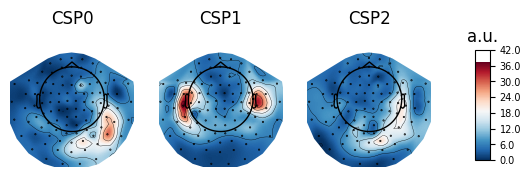

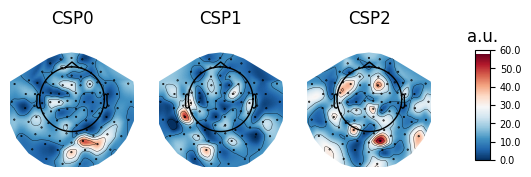

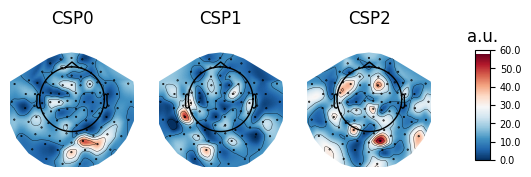

In [10]:
# Fit CSP on full data and plot
csp.fit(X, y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)

## Decoding over time

This strategy consists in fitting a multivariate predictive model on each
time instant and evaluating its performance at the same instant on new
epochs. The :class:`mne.decoding.SlidingEstimator` will take as input a
pair of features $X$ and targets $y$, where $X$ has
more than 2 dimensions. For decoding over time the data $X$
is the epochs data of shape n_epochs × n_channels × n_times. As the
last dimension of $X$ is the time, an estimator will be fit
on every time instant.

This approach is analogous to SlidingEstimator-based approaches in fMRI,
where here we are interested in when one can discriminate experimental
conditions and therefore figure out when the effect of interest happens.

When working with linear models as estimators, this approach boils
down to estimating a discriminative spatial filter for each time instant.

### Temporal decoding

We'll use a Logistic Regression for a binary classification as machine
learning model.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished


Text(0.5, 1.0, 'Sensor space decoding')

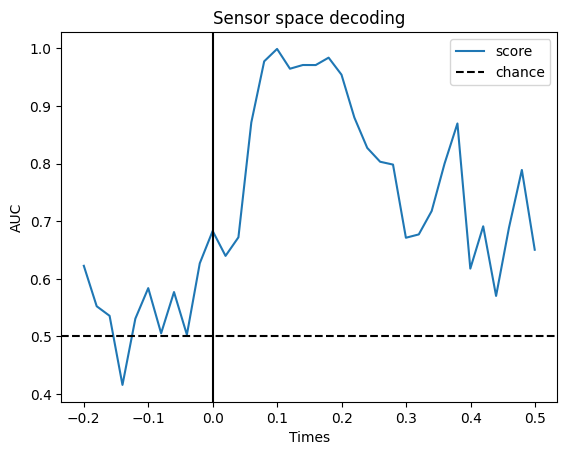

In [11]:
# We will train the classifier on all left visual vs auditory trials on MEG

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='roc_auc', verbose=True)
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

You can retrieve the spatial filters and spatial patterns if you explicitly
use a LinearModel



  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


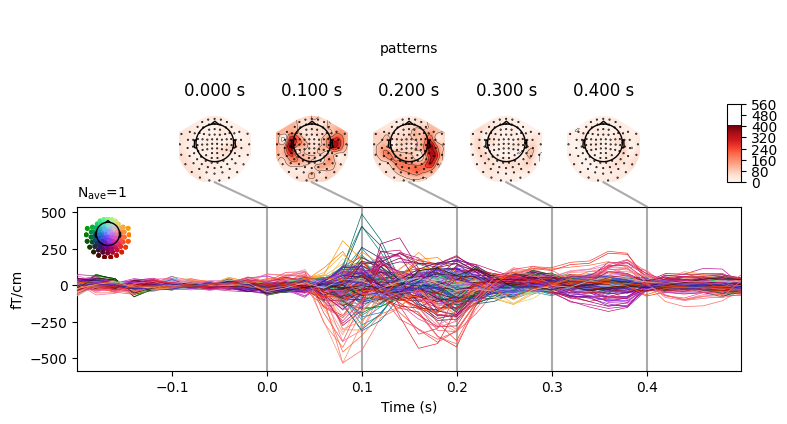

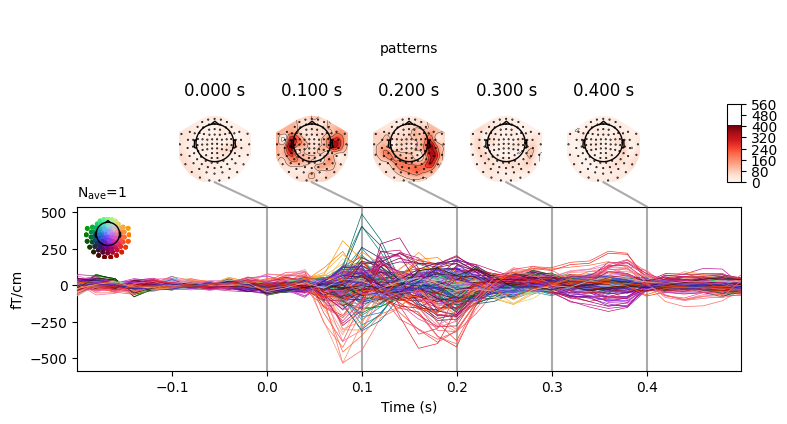

In [14]:
clf = make_pipeline(
    StandardScaler(),
    LinearModel(LogisticRegression(solver='liblinear'))
)
time_decod = SlidingEstimator(
    clf, n_jobs=None, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                           **joint_kwargs)

### Temporal generalization

Temporal generalization is an extension of the decoding over time approach.
It consists in evaluating whether the model estimated at a particular
time instant accurately predicts any other time instant. It is analogous to
transferring a trained model to a distinct learning problem, where the
problems correspond to decoding the patterns of brain activity recorded at
distinct time instants.

The object to for Temporal generalization is
:class:`mne.decoding.GeneralizingEstimator`. It expects as input $X$
and $y$ (similarly to :class:`~mne.decoding.SlidingEstimator`) but
generates predictions from each model for all time instants. The class
:class:`~mne.decoding.GeneralizingEstimator` is generic and will treat the
last dimension as the one to be used for generalization testing. For
convenience, here, we refer to it as different tasks. If $X$
corresponds to epochs data then the last dimension is time.

This runs the analysis used in :footcite:`KingEtAl2014` and further detailed
in :footcite:`KingDehaene2014`:



In [ ]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=None, scoring='roc_auc',
                                 verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')


In [22]:
'''

想查看到底用了多少个features

'''

time_gen.get_params()

{'base_estimator__memory': None,
 'base_estimator__steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(solver='liblinear'))],
 'base_estimator__verbose': False,
 'base_estimator__standardscaler': StandardScaler(),
 'base_estimator__logisticregression': LogisticRegression(solver='liblinear'),
 'base_estimator__standardscaler__copy': True,
 'base_estimator__standardscaler__with_mean': True,
 'base_estimator__standardscaler__with_std': True,
 'base_estimator__logisticregression__C': 1.0,
 'base_estimator__logisticregression__class_weight': None,
 'base_estimator__logisticregression__dual': False,
 'base_estimator__logisticregression__fit_intercept': True,
 'base_estimator__logisticregression__intercept_scaling': 1,
 'base_estimator__logisticregression__l1_ratio': None,
 'base_estimator__logisticregression__max_iter': 100,
 'base_estimator__logisticregression__multi_class': 'auto',
 'base_estimator__logisticregression__n_jobs': None,
 'base_estimator_

Plot the full (generalization) matrix:



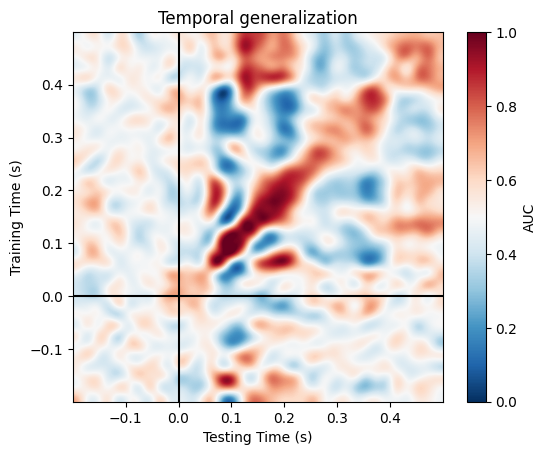

In [13]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')

## Projecting sensor-space patterns to source space
If you use a linear classifier (or regressor) for your data, you can also
project these to source space. For example, using our ``evoked_time_gen``
from before:



In [ ]:
cov = mne.compute_covariance(epochs, tmax=0.)
del epochs
fwd = mne.read_forward_solution(
    meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif')
inv = mne.minimum_norm.make_inverse_operator(
    evoked_time_gen.info, fwd, cov, loose=0.)
stc = mne.minimum_norm.apply_inverse(evoked_time_gen, inv, 1. / 9., 'dSPM')
del fwd, inv

And this can be visualized using :meth:`stc.plot <mne.SourceEstimate.plot>`:



In [ ]:
brain = stc.plot(hemi='split', views=('lat', 'med'), initial_time=0.1,
                 subjects_dir=subjects_dir)

## Source-space decoding

Source space decoding is also possible, but because the number of features
can be much larger than in the sensor space, univariate feature selection
using ANOVA f-test (or some other metric) can be done to reduce the feature
dimension. Interpreting decoding results might be easier in source space as
compared to sensor space.

.. topic:: Examples

    * `ex-dec-st-source`

## Exercise

 - Explore other datasets from MNE (e.g. Face dataset from SPM to predict
   Face vs. Scrambled)

## References
.. footbibliography::

